In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import scipy.optimize as opt
from scipy.optimize import curve_fit
import spinmob as s
import matplotlib.pylab as pylab

# import os 
# os.chdir('C:\\Users\\joeyb\\Documents\\Physics 359\\Hall')

In [15]:
def linear(V, m, b):
    return m*V + b

In [16]:
mv = (np.loadtxt('all_the_mv.csv', delimiter=',', skiprows = 1))

In [17]:
result = []
for sublist in mv:
    for item in sublist:
        result.append(item)
#print("\nCollapse nested lists:")
final_result = np.transpose(result)
# print(final_result)

TempArray = np.linspace(-270, 399, 670)

### Temp vs Voltage

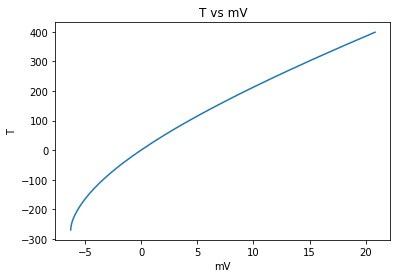

In [18]:
plt.plot(final_result, TempArray)
plt.title("T vs mV")
plt.xlabel('mV')
plt.ylabel('T')
plt.show()

### Trying with just taking linear approx on small scales

In [19]:
#splitting arrays in to 10 element arrays
mVArraysOf10 = np.split(final_result, len(final_result)/10)
TArraysOf10 = np.split(TempArray, len(final_result)/10)

for i in range(0, len(mVArraysOf10)):
    if (i != len(mVArraysOf10) - 1):
        mVArraysOf10[i] = np.append(mVArraysOf10[i], mVArraysOf10[i+1][0])
        TArraysOf10[i] = np.append(TArraysOf10[i], TArraysOf10[i+1][0])

    else:
        mVArraysOf10[i] = np.append(mVArraysOf10[i], mVArraysOf10[i-1][-1])
        TArraysOf10[i]= np.append(TArraysOf10[i], TArraysOf10[i-1][-1])


#get linear fit for each array of 10
fits = []

for i in range(0, int(len(final_result)/10)):
    popt, pcov = curve_fit(linear, mVArraysOf10[i], TArraysOf10[i])
    fits.append([popt, np.sqrt(np.diag(pcov))])
    
# print(fits[-1])
# perr = np.sqrt(np.diag(fits[0][0]))
# print(perr)

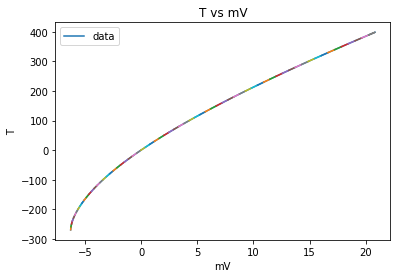

In [20]:
#plotting fits to make sure they match the data

plt.plot(final_result, TempArray, label="data")
plt.title("T vs mV")
plt.xlabel('mV')
plt.ylabel('T')
plt.legend()

for i in range(0, len(fits)):
    plt.plot(mVArraysOf10[i], linear(mVArraysOf10[i], fits[i][0][0], fits[i][0][1]))

plt.show()

## Errors
#### From Temp calibration  
LIMITS OF ERROR (whichever is greater)			
Standard	1.0Â°C or 0.75% Above 0Â°C	 1.0Â°C or 1.5% Below 0Â°C	
Special	0.5Â°C or 0.4%		
lets go with 1 degree for now

#### Model 199 DMM
0.0012(value) + 3^3 in last digit

In [21]:

"""
Takes input voltage (mV) and outputs corresponding temperature (C)
Must be run with mVArraysOf10[] and fits[]
Need errors


"""
def getTempFromVolt(V):
    fitted = False
    index = 0

    while fitted == False:
    #     print(min(mVArraysOf10[index]), (max(mVArraysOf10[index])) )
        if (min(mVArraysOf10[index]) <= V <= (max(mVArraysOf10[index])) ):
            TempVal = linear(V, fits[index][0][0], fits[index][0][1])
            fitted = True

        index+=1
        if index == len(fits):
            print("Error, Voltage not found.")
            TempVal = 0
            break
    
    return TempVal

def linearErr(V, erV, m, erM, b, erb):
    return np.sqrt( (m*V)**2*( (erM/m)**2+ (erV/V)**2) + (erb)**2 )

"""
Takes in a voltage and it's error.
Returns an array of the corresponding temp in kelvin and it's error
"""
def getTempFromVolt_Err(V, ErrV):
    fitted = False
    index = 0

    while fitted == False:
    #     print(min(mVArraysOf10[index]), (max(mVArraysOf10[index])) )
        if (min(mVArraysOf10[index]) <= V <= (max(mVArraysOf10[index])) ):
            TempVal = linear(V, fits[index][0][0], fits[index][0][1]) + 273.15
            fitted = True
            
            Err = linearErr(V, ErrV, fits[index][0][0], fits[index][1][0], fits[index][0][1], fits[index][1][1])
            #need to get errors
#             fits[index][1][0], fits[index][1][1] + error on V

        index+=1
        if index == len(fits):
            print("Error, Voltage not found.")
            TempVal = 0
            Err = 0
            break
    
    return [TempVal, Err]

In [34]:
# Use function to get temp for a given V
V = -1.66
VoltErr = 0.012*V + 3**3*(1e-7) #this is sorta for the wrong range

Temp = getTempFromVolt_Err(V, VoltErr)
            
print("%f (%f) K" %(Temp[0], Temp[1]))

227.795791 (0.588716) K


### Data from max angle - heating up

In [29]:
dataMandT = np.transpose((np.loadtxt('Data/2020-02-14 15_26 Voltage Readings Data_full.csv', delimiter=',', skiprows = 1)))
tempdataMandT = [getTempFromVolt(V) for V in dataMandT[7]*1e3]

8


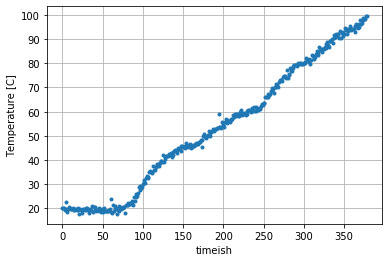

In [36]:
peak = np.where(tempdataMandT == np.amax(tempdataMandT))[0][0]
tempdataMandT = tempdataMandT[0:peak]
dataMandT = dataMandT[:, 0:peak]

print(len(dataMandT))

plt.plot(tempdataMandT, ls=" ", marker=".")

plt.grid()
plt.xlabel("timeish")
plt.ylabel("Temperature [C]")

plt.show()

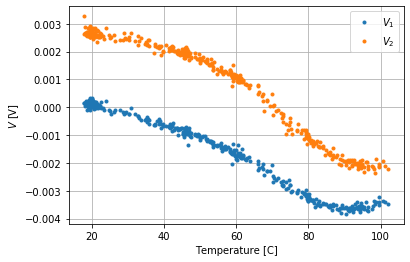

In [31]:
# print(len(data1), len(data))

plt.plot(tempdataMandT, dataMandT[0], ls=" ", marker=".", label="$V_1$")
plt.plot(tempdataMandT, dataMandT[1], ls=" ", marker=".", label="$V_2$")

# plt.plot(tempdata, data[2], ls=" ", marker=".")

plt.grid()
plt.ylabel("$V$ [V]")
plt.xlabel("Temperature [C]")
plt.legend()

plt.show()

### Data from min angle - full range hopefully

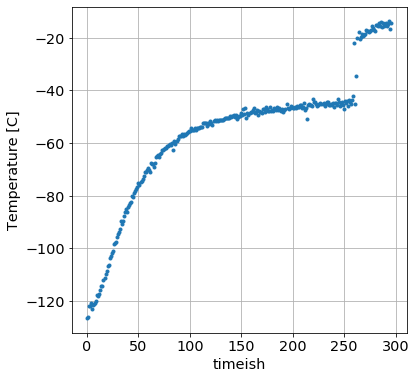

In [46]:
#we're gonna have to cut the top of this as we were making ajustmenets
dataHigher = np.transpose((np.loadtxt('Data/2020-02-17 14_28 Voltage Readings Data.csv', delimiter=',', skiprows = 1)))
dataHigher = dataHigher[:, 75:]
tempDataHigher = [getTempFromVolt(V) for V in dataHigher[7]*1e3]

TempDataCom = tempDataHigher
DataCom = dataHigher

plt.plot(TempDataCom, ls=" ", marker=".")

plt.grid()
plt.xlabel("timeish")
plt.ylabel("Temperature [C]")

plt.show()

## Fits

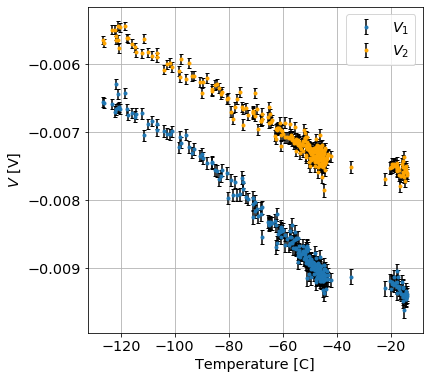

In [47]:
DataCom_Err = []
errStatic = 3**3*(1e-7)

for row in DataCom:
    row_err = []
    for ele in row:
#         print(ele)
        row_err.append(0.012*ele + errStatic) 
        
    DataCom_Err.append(row_err)
    
# print(DataCom_Err[0][0])

plt.errorbar(TempDataCom, DataCom[0], yerr=DataCom_Err[0], ls=" ", marker=".", label="$V_1$", ecolor='black', capsize=2)
plt.errorbar(TempDataCom, DataCom[1], yerr=DataCom_Err[1], ls=" ", marker=".", label="$V_2$", ecolor='black', capsize=2, color="orange")

plt.grid()
plt.ylabel("$V$ [V]")
plt.xlabel("Temperature [C]")
plt.legend()

plt.show()

### Porbs don't need this stuff rn

In [40]:
#sorting data in order of Temp
DataComS = DataCom
DataComS = np.transpose(DataCom)

index = DataComS[: , -1].argsort()
DataComSorted = []

for i in range(0, len(index)):
    DataComSorted.append(DataComS[index[i]])

In [41]:
DataComSORT = np.transpose(DataComSorted)

DataCom_Err = []
errStatic = 3**3*(1e-7)

for row in DataComSORT:
    row_err = []
    for ele in row:
        row_err.append(0.012*ele + errStatic) 
#     print(len(row_err))

    DataCom_Err.append(row_err)
    
DataCom_Err = np.array(DataCom_Err)

TempDataComErr = [getTempFromVolt_Err(DataComSORT[7][i]*1e3, DataCom_Err[7][i]*1e3) for i in range(0, len(DataComSORT[0])) ]
TempDataComErr = np.transpose(TempDataComErr)

TempDataComKSORT = np.array(TempDataComErr)

Peak split value:[215.97036062   0.67343703]


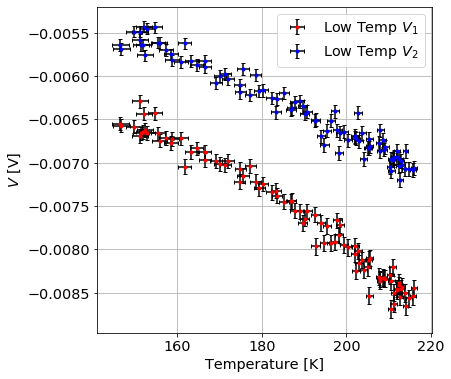

In [45]:
peak = np.where(DataComSORT == np.amax(DataComSORT))[1][0]
# print(peak)
print("Peak split value:" + str(TempDataComKSORT[:,peak]))

DataComLow = DataComSORT[:,0:peak]
TempDataComLow = TempDataComKSORT[:,0:peak]
DataCom_ErrLow = DataCom_Err[:, 0:peak]

DataComHigh = DataComSORT[:,peak:-1]
TempDataComHigh = TempDataComKSORT[:,peak:-1]
DataCom_ErrHigh = DataCom_Err[:, peak:-1]

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.errorbar(TempDataComLow[0], DataComLow[0], yerr=DataCom_ErrLow[0], xerr=TempDataComLow[1], ls=" ", marker=".", label="Low Temp $V_1$", ecolor='black', capsize=2, color="red")
# plt.errorbar(TempDataComHigh[0], DataComHigh[4], yerr=DataCom_ErrHigh[4], xerr=TempDataComHigh[1], ls=" ", marker=".", label="High Temp $V_5$", ecolor='black', capsize=2, color="orange")

plt.errorbar(TempDataComLow[0], DataComLow[1], yerr=DataCom_ErrLow[1], xerr=TempDataComLow[1], ls=" ", marker=".", label="Low Temp $V_2$", ecolor='black', capsize=2, color="blue")
# plt.errorbar(TempDataComHigh[0], DataComHigh[5], yerr=DataCom_ErrHigh[5], xerr=TempDataComHigh[1], ls=" ", marker=".", label="High Temp $V_6$", ecolor='black', capsize=2, color="green")


plt.grid()
plt.ylabel("$V$ [V]")
plt.xlabel("Temperature [K]")
plt.legend()

plt.show()